In [35]:
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

In [36]:
# settles = pd.read_csv('../data/rb_settles_20210924.csv')


def get_settles_df(symbol:str, date:str) -> pd.DataFrame:
    url = f"http://settles-api.mosaic.hartreepartners.com/settles/api/v1/getFutureCurveSettlement/{symbol}/CME/{date}?allow_indicative=true"
    data = requests.get(url)
    df = pd.DataFrame(data=data.json())
    return df[['instrument_key','expiration_date','value']].reset_index(drop=True)

In [37]:
settles_t_1 = get_settles_df("RB", "2021-09-24")
settles_t_2 = get_settles_df("RB", "2021-09-23")
live = pd.read_csv('../data/RB_live_prices_20210927.csv')

In [38]:
# transform
settles_t_1.rename(columns={'value':'t-1'}, inplace=True)
settles_t_2.rename(columns={'value':'t-2'}, inplace=True)
live['live_price'] = (live['bid'] + live['ask'])/2
live.rename(columns={'instr':'instrument_key'}, inplace=True)
settles = pd.merge(settles_t_1, settles_t_2, how="inner", on=["instrument_key","expiration_date"])

In [39]:
live_futures = live[~live['instrument_key'].str.contains('-')].reset_index(drop=True).copy()
settles_futures = settles.copy()


In [40]:
df = pd.merge(settles_futures,live_futures,how="left",on='instrument_key')
df = df[['instrument_key','expiration_date','t-1','t-2','live_price']].copy()
df[['symbol','contract']] = df['instrument_key'].str.split(expand=True)
df['diff'] = df['t-1'] - df['t-2']

In [41]:
df = df.where(pd.notna(df),None).copy()
df.sort_values(by='instrument_key', inplace=True)

In [42]:
df['settles_price'] = df.apply(lambda row: None if row['live_price'] is None else row['t-1'], axis=1)
df['missing'] = df['live_price'].apply(lambda x:True if x is None else False)
df = df.where(pd.notna(df),None)
df = df.reset_index()

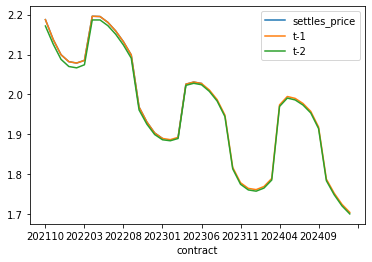

In [43]:
fig = df[['contract','settles_price','t-1','t-2']].plot(x='contract').get_figure()
fig.savefig(r'c:\temp\linear_models.pdf')

In [44]:
# df['missing'] = df['missing'] * df['live_price']


In [45]:
df['price_flag'] = df['settles_price'].apply(lambda x: 0 if x is None else 1)

# using index weighting
# def derive_price_v1(row):
#     if row['price_flag'] == 0:
#         # find the *last* row with non null price before this row
#         row_before = df.loc[(df['index'] < row['index']) & (df['price_flag'] == 1)].iloc[-1]
#         
#         # find the first row with non null price after this row
#         row_after = None
#         if row['index'] == (df.shape[0] - 1):
#             row_after = None
#         else:
#             row_after_df = df.loc[(df['index'] > row['index']) & (df['price_flag'] == 1)].copy()
#             if len(row_after_df) > 0:
#                 row_after = row_after_df.iloc[0].copy()
#                 
#         if row_after is None:
#             row['derived_price'] = row['t-1'] + row['diff']
#         else:
#             w1 = (row['index']- row_before['index'])/(row_after['index'] - row_before['index'])
#             w2 = 1 - w1
#             print(f"{w1} {w2} {row_before['settles_price']} {row_after['settles_price']} derived={w1 * row_before['settles_price'] + w2 * row_after['settles_price']}")
#             row['derived_price'] = w1 * row_before['settles_price'] + w2 * row_after['settles_price']
#     else:
#         row['derived_price'] = row['settles_price']
#         
#     return row  
# 
# df_n = df.apply(derive_price_v1, axis=1)

In [46]:
df['expiration_date'] = pd.to_datetime(df['expiration_date'])
df['days_from_today'] = df['expiration_date'].apply(lambda x: (x - datetime.datetime.today()).days)
# using expiry date weighting
# def derive_price_v2(row):
#     if row['price_flag'] == 0:
#         # find the *last* row with non null price before this row
#         row_before = df.loc[(df['index'] < row['index']) & (df['price_flag'] == 1)].iloc[-1]
#         
#         # find the first row with non null price after this row
#         row_after = None
#         if row['index'] == (df.shape[0] - 1):
#             row_after = None
#         else:
#             row_after_df = df.loc[(df['index'] > row['index']) & (df['price_flag'] == 1)].copy()
#             if len(row_after_df) > 0:
#                 row_after = row_after_df.iloc[0].copy()
#                 
#         if row_after is None:
#             row['derived_price'] = row['t-1'] + row['diff']
#         else:
#             w1 = (row['expiration_date']- row_before['expiration_date']).days/(row_after['expiration_date'] - row_before['expiration_date']).days
#             w2 = 1 - w1
#             print(f"{w1} {w2} {row_before['settles_price']} {row_after['settles_price']} derived={w1 * row_before['settles_price'] + w2 * row_after['settles_price']}")
#             row['derived_price'] = w2 * row_before['settles_price'] + w1 * row_after['settles_price']
#     else:
#         row['derived_price'] = row['settles_price']
#         
#     return row  
# 
# df_n2 = df.apply(derive_price_v2, axis=1)

In [47]:
# df_n[['contract','derived_price','t-1']].plot(x='contract')

In [48]:
# fig, ax = plt.subplots(figsize=(35, 5), )
# 
# 
# ax.plot(df_n2['contract'], df_n['derived_price'], '-gx', markevery=list(df_n2['missing']) , label='t-1')
# ax.plot(df_n2['contract'], df_n2['t-1'], label='t-1')
# # ax.plot(df['contract'], df['live_price'], label='live_price')
# # ax.plot(df_n['contract'], df['t-2'], label='t-2')
# fig.savefig(r'c:\temp\linear_models_v4.pdf')

In [52]:
# using scipy interpolation

df['expiration_date'] = pd.to_datetime(df['expiration_date'])
df['days_to_expiry'] = df['expiration_date'].apply(lambda x: (x - datetime.datetime.today()).days)

In [53]:
df_sub = df[['days_to_expiry','settles_price']].dropna()
f=interpolate.interp1d(df_sub['days_to_expiry'],df_sub['settles_price'])

In [54]:
df = df.where(pd.notna(df),None).copy()
def func(row):
    if row['settles_price'] is None:
        row['derived_price_3'] = pd.Series(f(np.array([row['days_to_expiry']])))[0]
    else:
        row['derived_price_3'] = row['settles_price']
        
    return row

df = df.apply(func,axis=1 )

# df['derived_price_2'] = f(list(df['days_to_expiry']))

ValueError: A value in x_new is above the interpolation range.

In [ ]:
print(pd.Series(f(np.array([486.0])))[0])
